Table 1. Description of dendrogram for 2002–2005 (N and Distance)
|   Cluster |   Count |   Distance |
|----------:|--------:|-----------:|
|         1 |       6 |    26816.8 |
|         2 |       8 |    16264.4 |
|         3 |      13 |    18360.8 |

Table 2. Mean values for significant variables for 2002–2005
|   Cluster |   Food_Index |   Agri_ValueAdded_perCapita |   Agri_ValueAdded_pctGDP |   Livestock_Index |
|----------:|-------------:|----------------------------:|-------------------------:|------------------:|
|         1 |       101    |                    54789.2  |                     1.89 |            102.91 |
|         2 |       100.09 |                    29397.8  |                     1.95 |            100.61 |
|         3 |        98.1  |                     9416.39 |                     5.09 |             99.1  |


Table 3. Description of dendrogram for 2006–2009 (N and Distance)
|   Cluster |   Count |   Distance |
|----------:|--------:|-----------:|
|         1 |  

C:\Users\86182\AppData\Local\Temp\ipykernel_30380\1785373745.py:135: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


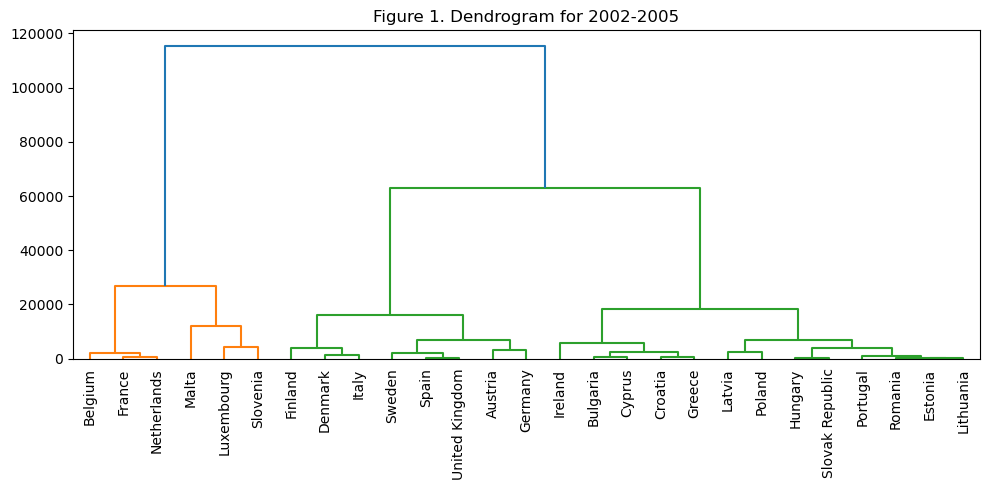

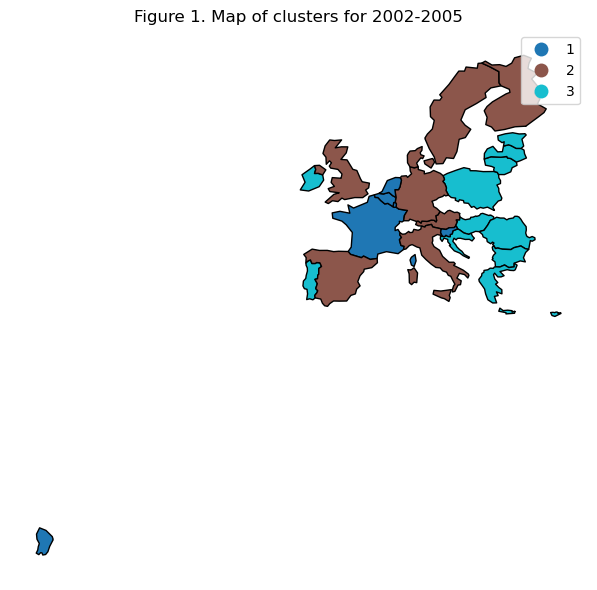

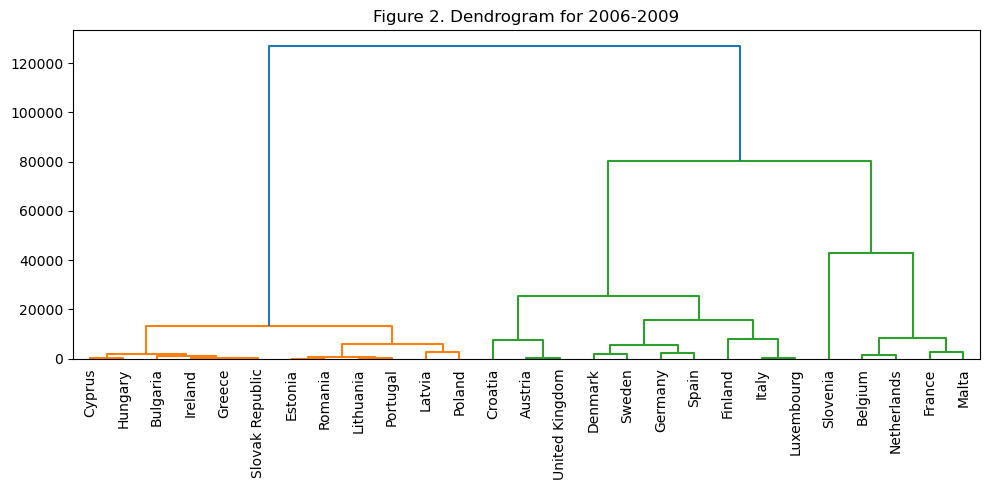

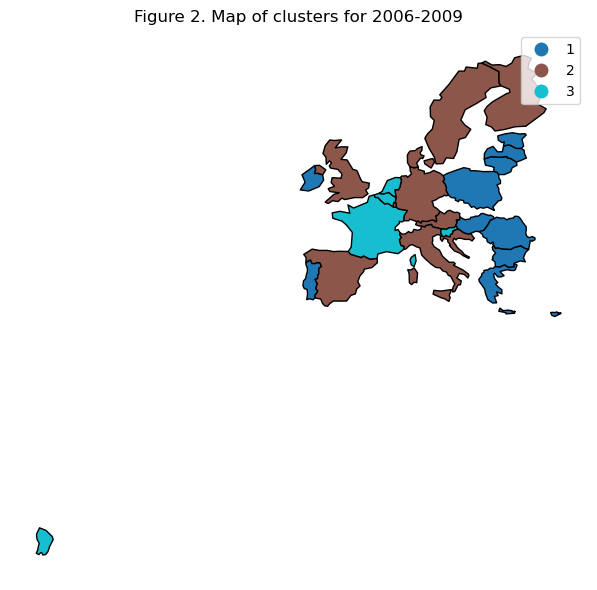

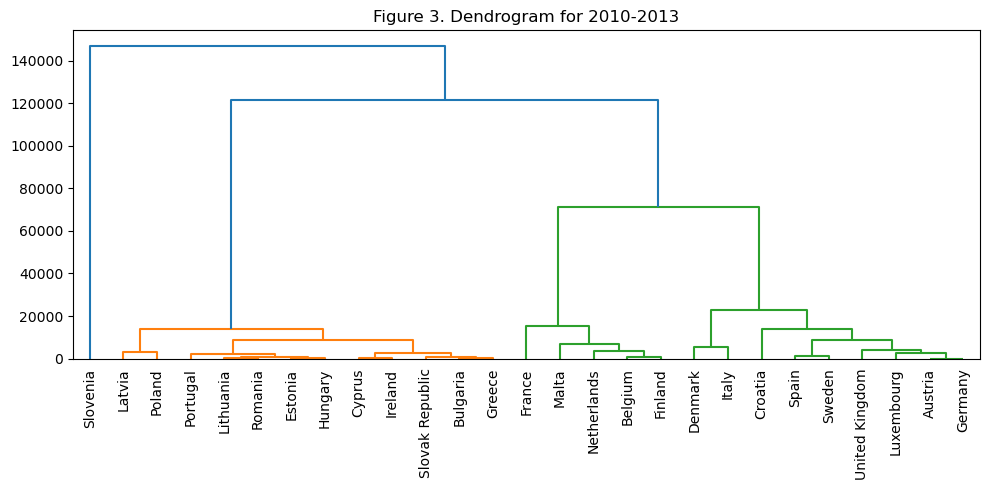

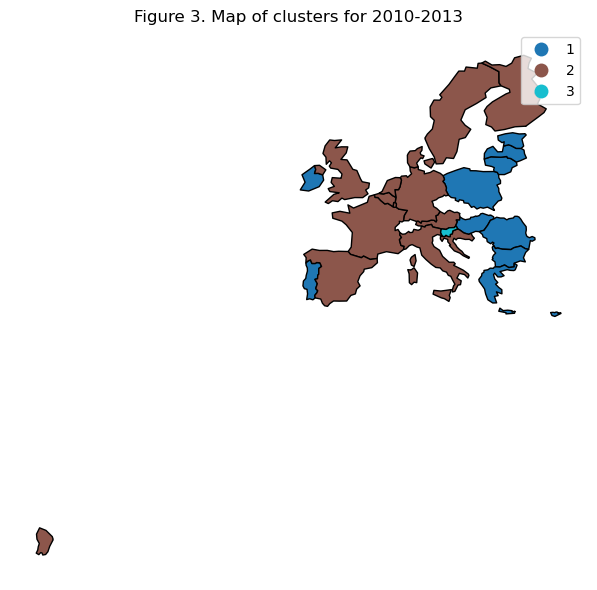

Figure 4. Mean values of agriculture value added per worker for each cluster and period
|   Cluster |   2002-2005 |   2006-2009 |   2010-2013 |
|----------:|------------:|------------:|------------:|
|         1 |    54789.2  |     9300.91 |     11035.5 |
|         2 |    29397.8  |    33700.2  |     44826.9 |
|         3 |     9416.39 |    64794    |    135039   |


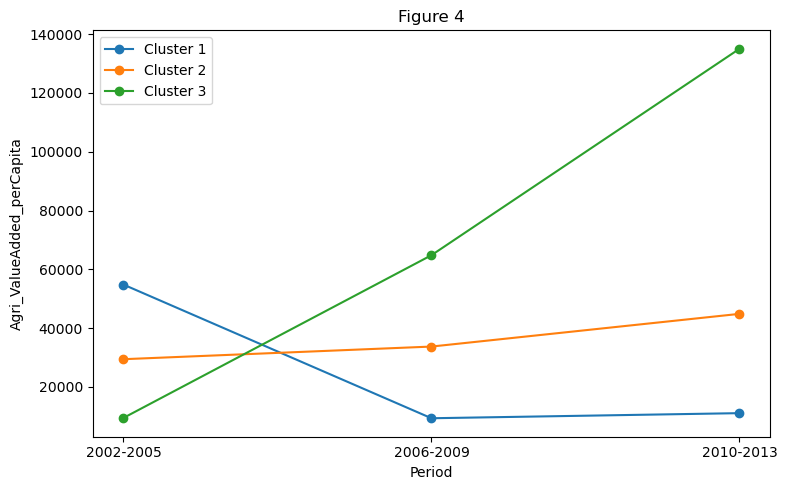

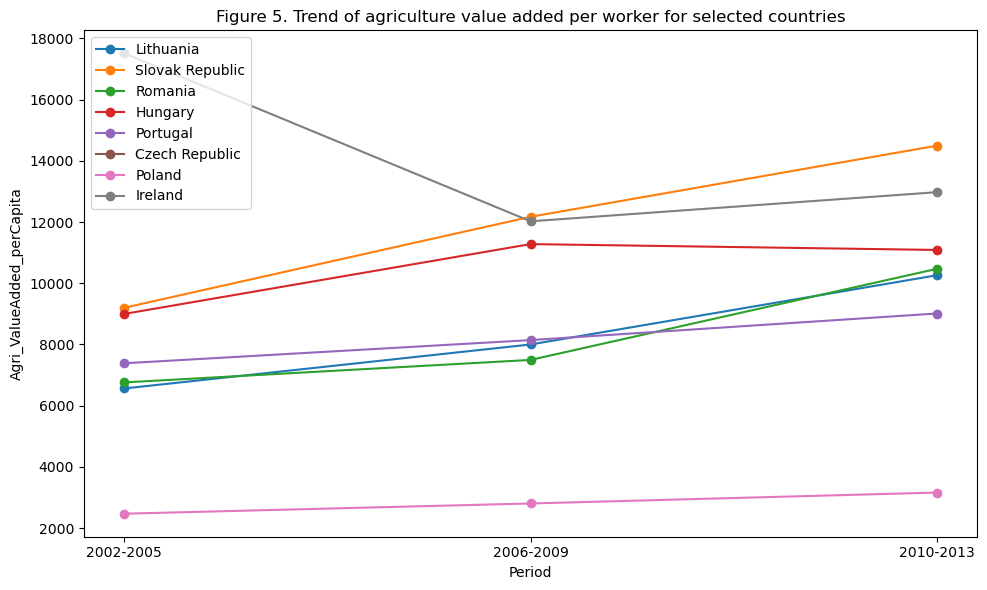

Figure 6. Mean values of agriculture value added (% of GDP) for each cluster and period
|   Cluster |   2002-2005 |   2006-2009 |   2010-2013 |
|----------:|------------:|------------:|------------:|
|         1 |        1.89 |        3.55 |        3.6  |
|         2 |        1.95 |        1.81 |        1.77 |
|         3 |        5.09 |        1.74 |        2.1  |


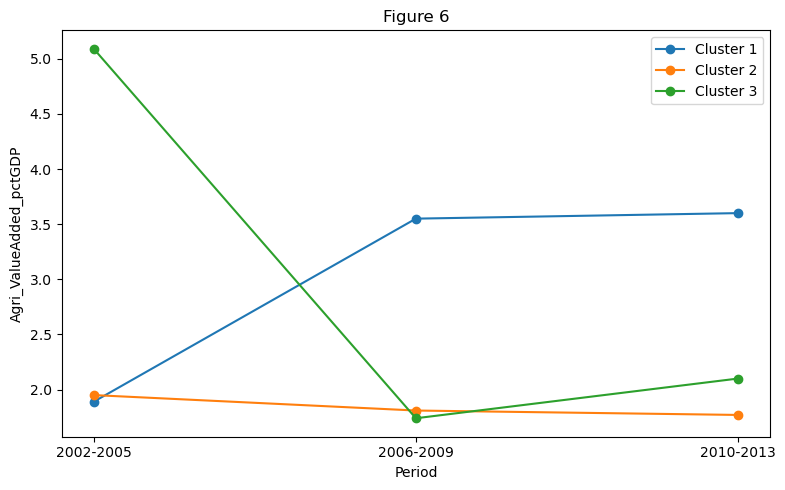

In [14]:
#!/usr/bin/env python3
"""
Script: reproduce_R6_analysis.py
Description: Generate Tables 1–6 and Figures 1–6 from R6.
Environment:
  - Python 3.8+
  - pandas, numpy, scipy, matplotlib, geopandas
Usage:
  $ python reproduce_R6_analysis.py
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import kruskal

# Load data
df = pd.read_csv('R6_extracted_from_WDI.csv')
indicator_cols = [c for c in df.columns if c not in ['Country','Period','Year']]
periods = ['2002-2005','2006-2009','2010-2013']
clustered = {}

# helper function to compute per-cluster cut heights
def cluster_cut_heights(Z, labels, n_clusters):
    """
    计算每个簇被割断时的高度。
    Z: linkage matrix
    labels: fcluster 输出的簇标签数组
    n_clusters: 簇的数量
    返回 dict {cluster_label: height}
    """
    m = len(labels)
    # 初始化每个样本所在的小簇
    clusters = {i:[i] for i in range(m)}
    heights = {}
    # 遍历合并记录
    for idx, (c1, c2, dist, cnt) in enumerate(Z):
        c1, c2 = int(c1), int(c2)
        new_id = m + idx
        members = clusters[c1] + clusters[c2]
        # 检查每个簇标签是否首次出现在 members 中
        for k in range(1, n_clusters+1):
            if k not in heights:
                # 找到该簇的样本索引
                inds = [i for i, lab in enumerate(labels) if lab==k]
                # 如果这些样本均在当前 members 中，则记录当前 dist
                if all(i in members for i in inds):
                    heights[k] = dist
        clusters[new_id] = members
        del clusters[c1]; del clusters[c2]
    return heights

# 1. Table 1: cluster sizes and per-cluster distance for 2002–2005
p0 = periods[0]
df0 = df[df['Period']==p0].dropna(subset=indicator_cols)
Z0 = linkage(df0[indicator_cols], method='ward')
clusters0 = fcluster(Z0, 3, 'maxclust')
df0['Cluster'] = clusters0
clustered[p0] = df0
# cluster counts
t1 = df0['Cluster'].value_counts().sort_index().rename_axis('Cluster').reset_index(name='Count')
# compute per-cluster cut heights
heights0 = cluster_cut_heights(Z0, clusters0, 3)
t1['Distance'] = t1['Cluster'].map(lambda k: round(heights0[k],2))
print('Table 1. Description of dendrogram for 2002–2005 (N and Distance)')
print(t1.to_markdown(index=False))
print()

# 2. Table 2: mean values for significant variables 2002–2005 Table 2: mean values for significant variables 2002–2005
sig = []
for col in indicator_cols:
    vals = [g[col].values for _,g in df0.groupby('Cluster')]
    H,p = kruskal(*vals)
    if p<0.05:
        sig.append(col)
# Ensure inclusion of Livestock production index and agriculture value added per worker
mandatory = ['Livestock_Index', 'Agri_ValueAdded_perCapita']
for m in mandatory:
    if m in indicator_cols and m not in sig:
        sig.append(m)
# Compute mean values for significant and mandatory variables
t2 = df0.groupby('Cluster')[sig].mean().round(2).reset_index()
print('Table 2. Mean values for significant variables for 2002–2005')
print(t2.to_markdown(index=False))
print()
print()

# 3. Table 3: cluster sizes and per-cluster distance for 2006–2009
p1 = periods[1]
df1 = df[df['Period']==p1].dropna(subset=indicator_cols)
Z1 = linkage(df1[indicator_cols], method='ward')
clusters1 = fcluster(Z1, 3, 'maxclust')
df1['Cluster'] = clusters1
clustered[p1] = df1
t3 = df1['Cluster'].value_counts().sort_index().rename_axis('Cluster').reset_index(name='Count')
# compute per-cluster cut heights
heights1 = cluster_cut_heights(Z1, clusters1, 3)
t3['Distance'] = t3['Cluster'].map(lambda k: round(heights1[k],2))
print('Table 3. Description of dendrogram for 2006–2009 (N and Distance)')
print(t3.to_markdown(index=False))
print()

# 4. Table 4: stats for agriculture value added per worker 2006–2009 (include median)
avpw = 'Agri_ValueAdded_perCapita'
# compute mean, median, std, min, max
t4 = df1.groupby('Cluster')[avpw].agg(['mean','median','std','min','max']).round(2).reset_index()
print('Table 4. Summary statistics for agriculture value added per worker (2006–2009)')
print(t4.to_markdown(index=False))
print()

# 5. Table 5: cluster sizes and per-cluster distance for 2010–2013. Table 5: cluster sizes and per-cluster distance for 2010–2013
p2 = periods[2]
df2 = df[df['Period']==p2].dropna(subset=indicator_cols)
Z2 = linkage(df2[indicator_cols], method='ward')
clusters2 = fcluster(Z2, 3, 'maxclust')
df2['Cluster'] = clusters2
clustered[p2] = df2
t5 = df2['Cluster'].value_counts().sort_index().rename_axis('Cluster').reset_index(name='Count')
# compute per-cluster cut heights
heights2 = cluster_cut_heights(Z2, clusters2, 3)
t5['Distance'] = t5['Cluster'].map(lambda k: round(heights2[k],2))
print('Table 5. Description of dendrogram for 2010–2013 (N and Distance)')
print(t5.to_markdown(index=False))
print()

# 6. Table 6: stats for agriculture value added per worker 2010–2013 (include median)
# compute mean, median, std, min, max
t6 = df2.groupby('Cluster')[avpw].agg(['mean','median','std','min','max']).round(2).reset_index()
print('Table 6. Summary statistics for agriculture value added per worker (2010–2013)')
print(t6.to_markdown(index=False))
print()

# Figures 1-3: dendrograms and maps-3: dendrograms and maps
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
for i,(period,Z,dframe) in enumerate([(p0,Z0,df0),(p1,Z1,df1),(p2,Z2,df2)],1):
    plt.figure(figsize=(10,5))
    dendrogram(Z, labels=dframe['Country'].tolist(), leaf_rotation=90)
    plt.title(f'Figure {i}. Dendrogram for {period}')
    plt.tight_layout(); plt.show()
    # map
    eu = world[world['name'].isin(dframe['Country'])]
    eu = eu.merge(dframe[['Country','Cluster']], left_on='name', right_on='Country')
    fig,ax = plt.subplots(figsize=(8,6))
    eu.plot(column='Cluster', categorical=True, legend=True, ax=ax, edgecolor='black')
    ax.set_title(f'Figure {i}. Map of clusters for {period}')
    ax.axis('off'); plt.tight_layout(); plt.show()

# Figure 4: mean avpw by cluster across periods
fig4 = pd.DataFrame({period: clustered[period].groupby('Cluster')[avpw].mean() for period in periods}).round(2)
fig4.index.name='Cluster'; fig4.reset_index(inplace=True)
print('Figure 4. Mean values of agriculture value added per worker for each cluster and period')
print(fig4.to_markdown(index=False))
plt.figure(figsize=(8,5))
for cl in fig4['Cluster']:
    vals = fig4[fig4['Cluster']==cl][periods].values.flatten()
    plt.plot(periods, vals, marker='o', label=f'Cluster {cl}')
plt.title('Figure 4'); plt.xlabel('Period'); plt.ylabel(avpw)
plt.legend(); plt.tight_layout(); plt.show()

# Figure 5: trends for selected countries
selected = ['Lithuania','Slovak Republic','Romania','Hungary','Portugal','Czech Republic','Poland','Ireland']
plt.figure(figsize=(10,6))
for c in selected:
    sub = df[df['Country']==c]
    plt.plot(sub['Period'], sub[avpw], marker='o', label=c)
plt.title('Figure 5. Trend of agriculture value added per worker for selected countries')
plt.xlabel('Period'); plt.ylabel(avpw)
plt.legend(); plt.tight_layout(); plt.show()

# Figure 6: mean agri % GDP by cluster across periods
avpg='Agri_ValueAdded_pctGDP'
fig6 = pd.DataFrame({period: clustered[period].groupby('Cluster')[avpg].mean() for period in periods}).round(2)
fig6.index.name='Cluster'; fig6.reset_index(inplace=True)
print('Figure 6. Mean values of agriculture value added (% of GDP) for each cluster and period')
print(fig6.to_markdown(index=False))
plt.figure(figsize=(8,5))
for cl in fig6['Cluster']:
    vals=fig6[fig6['Cluster']==cl][periods].values.flatten()
    plt.plot(periods, vals, marker='o', label=f'Cluster {cl}')
plt.title('Figure 6'); plt.xlabel('Period'); plt.ylabel(avpg)
plt.legend(); plt.tight_layout(); plt.show()
